# Car Sales Analysis 
<br>

# Intoduction
This document contains the analysis of a car sales dataset spanning from the beginning of 2022 to the end of 2023. My aim is to uncover patterns, relationships and also predictive insights into the automotive market. By diving into this dataset in 4 different sections I aim to understand how economic and demographic factors can influence car purchasing decisions, identify the customer profile that is the most profitable, dive into statistical behaviour with regards to purchasing cars and use predictive analytics to determine future trends.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

%config InlineBackend.figure_format = 'retina' 


df = pd.read_csv('Dataset.csv')


cols_to_clean = ['Annual Income', 'Price ($)']

for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df.dropna(subset=cols_to_clean, inplace=True)


df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


cat_cols = ['Body Style', 'Gender', 'Company', 'Model', 'Dealer_Region']
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip()

print(f"Data Cleaned. Remaining Rows: {len(df)}")


bins = [0, 100000, 250000, 500000, 1000000, 2500000, 5000000]
labels = ['0-$100K', '$100K-$250K', '$250K-$500K', '$500K-$1M', '$1M-$2.5M', '>$2.5M']
df['Income Bracket'] = pd.cut(df['Annual Income'], bins=bins, labels=labels)


price_bins = [0, 15000, 25000, 35000, 50000, 75000, 100000, 150000, 200000]
price_labels = ['<$15K', '$15K-$25K', '$25K-$35K', '$35K-$50K', '$50K-$75K', '$75K-$100K', '$100K-$150K', '>$150K']
df['Price Bracket'] = pd.cut(df['Price ($)'], bins=price_bins, labels=price_labels)

Data Cleaned. Remaining Rows: 23906


# Section 1: Analysing Car Brand and Model Preferences Across Income Segments
<b>Objective:</b> <br>
I wanted explore the various consumer income brakcets and see how they influence car brands and models. Furthermore, I wanted to take a deep dive into certain brands and models to determine if they attract high-income individuals vs low-income individuals and also examine whether price is aligned with income levels across various segments.

<b> Key Questions to be answered: </b>
- Do higher-income brackets show a clear preference for luxury or premium car brands?
- Is there a strong relationship between a buyer's income and the price of the car purchased?
- Are there specific car brands that appeal across multiple income brackets?
- Are certain car brands associated predominantly with middle-income consumers?
- Is there a difference in average car price within a brand across different income levels?

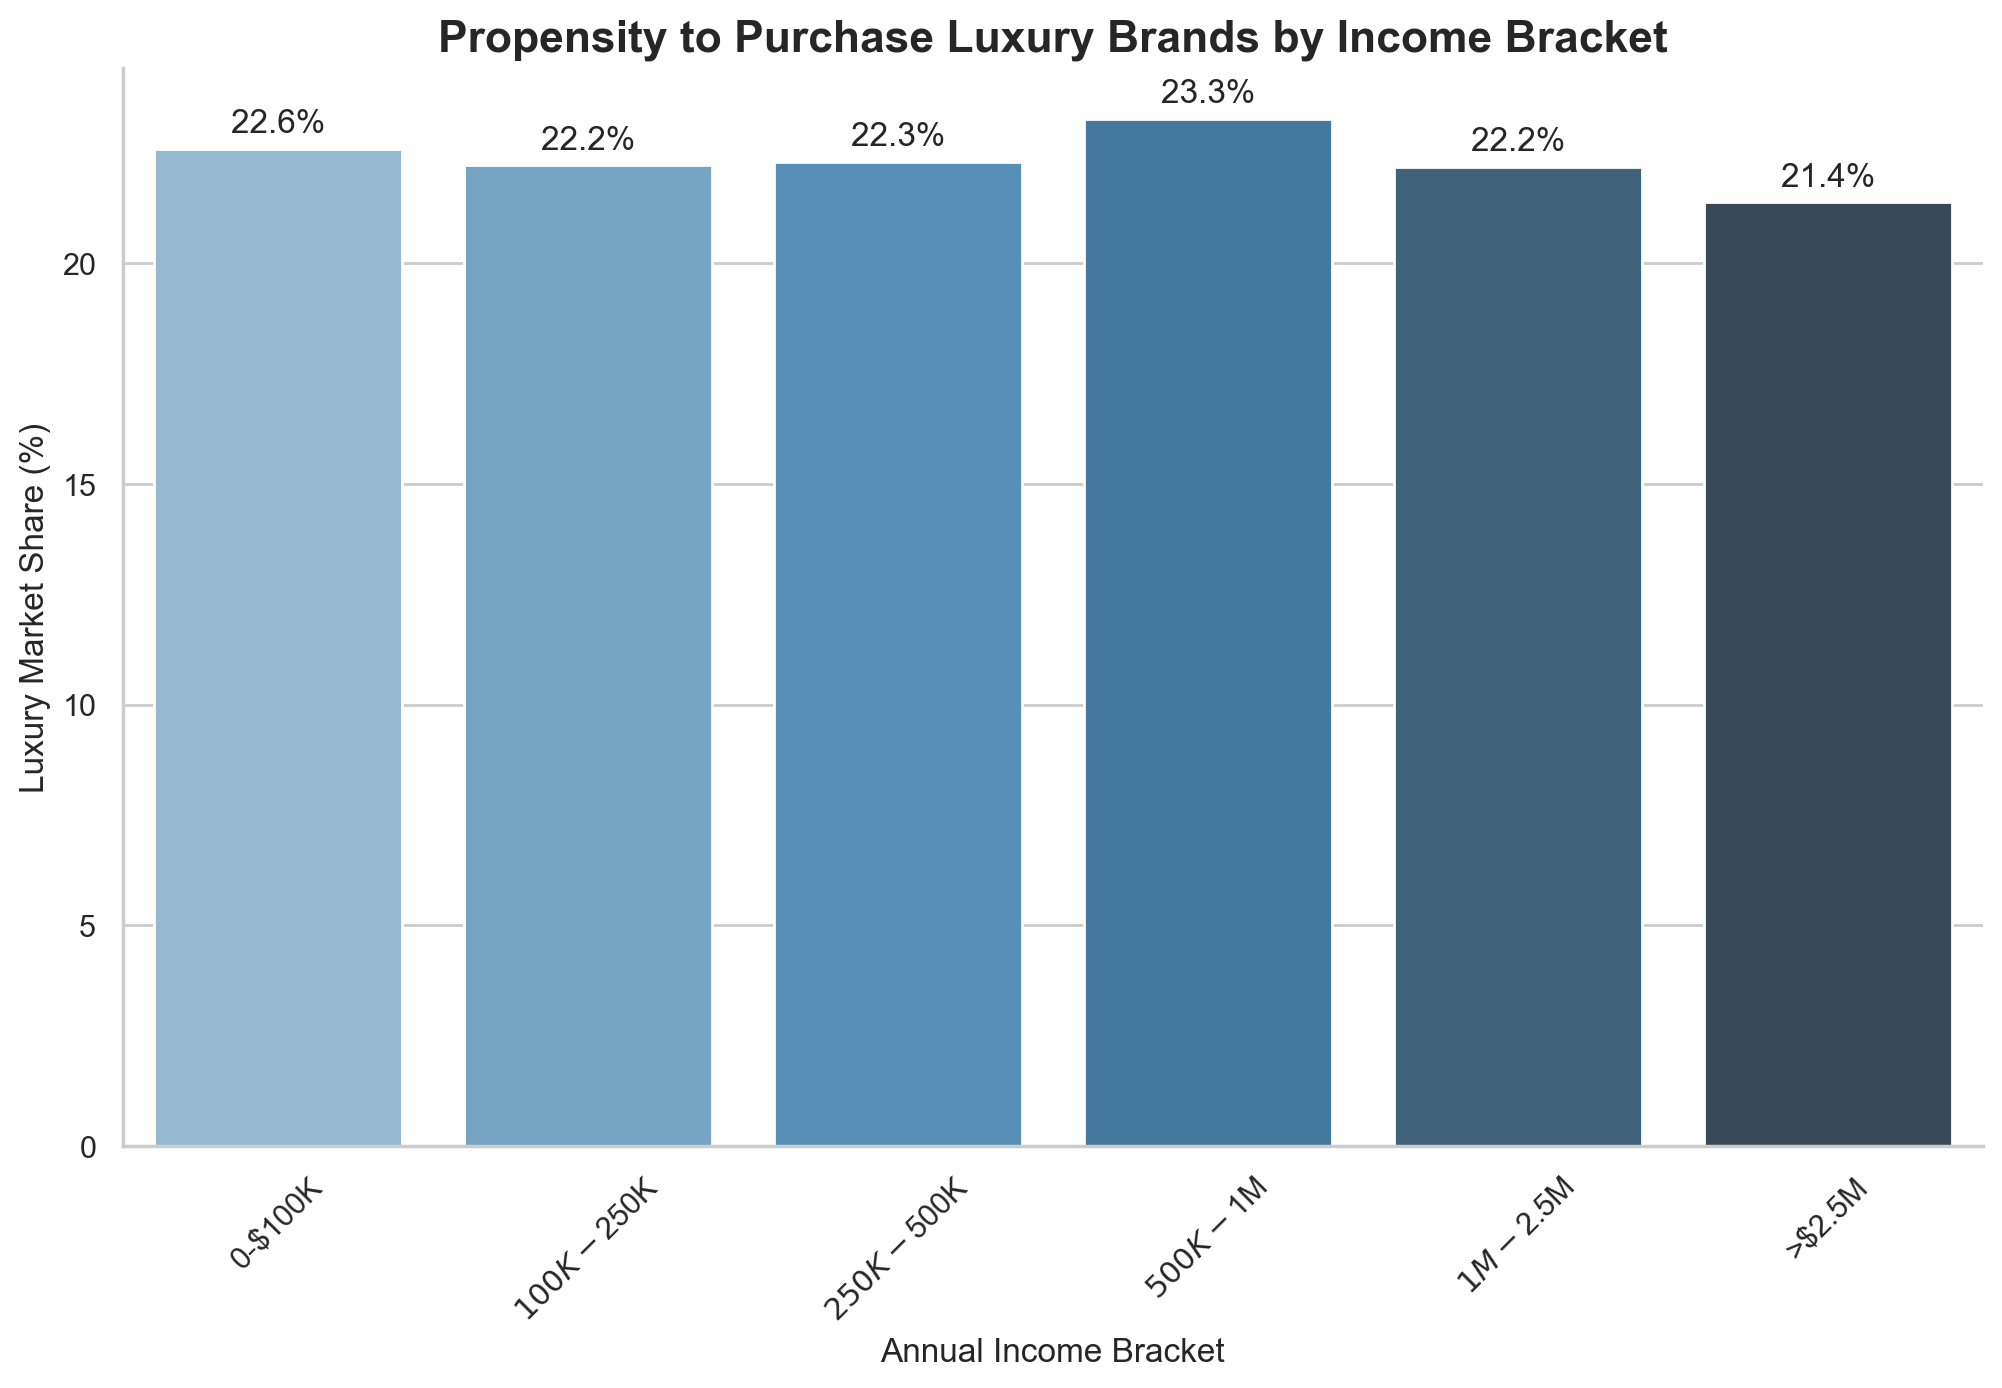

In [10]:
# Analysis: Luxury Brand Penetration
luxury_brands = ['BMW', 'Mercedes-B', 'Audi', 'Lexus', 'Jaguar', 'Porsche', 'Infiniti', 'Acura', 'Cadillac']
df['Is_Luxury'] = df['Company'].isin(luxury_brands)


luxury_by_income = df.groupby('Income Bracket')['Is_Luxury'].mean() * 100


plt.figure(figsize=(12, 7))

ax = sns.barplot(x=luxury_by_income.index, y=luxury_by_income.values, palette="Blues_d")

plt.title('Propensity to Purchase Luxury Brands by Income Bracket', fontsize=16, fontweight='bold')
plt.xlabel('Annual Income Bracket', fontsize=12)
plt.ylabel('Luxury Market Share (%)', fontsize=12)
plt.xticks(rotation=45)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

sns.despine() 
plt.show()

The chart above illustrates the percentage of luxury brands that are bought by different income brackets, and from it we can conclude that people who earn between 500k dollars and 1M dollars per anum buy the most amount of luxury cars. It is interesting to see that people that earn less than 50k dollars are not far behind them when it comes to purchasing luxury brands. There is no clear trend here and the data looks to be very consisten across all income brackets.

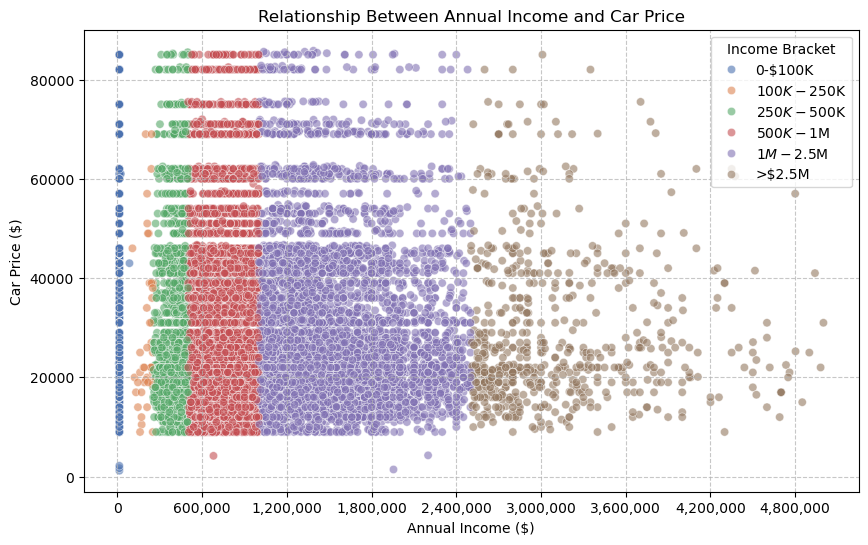

Correlation between Annual Income and Car Price: 0.01


In [75]:
# Checking for correlation between annual income and car price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income', y='Price ($)', hue='Income Bracket', data=df, palette='deep', alpha=0.6)
plt.title('Relationship Between Annual Income and Car Price')
plt.xlabel('Annual Income ($)')
plt.ylabel('Car Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Income Bracket')

plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) 
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))  

plt.show()

correlation = df['Annual Income'].corr(df['Price ($)'])
print(f"Correlation between Annual Income and Car Price: {correlation:.2f}")

The chart above shows the relationship between annual income and car price. There is a weak positive correlation (no linear relationship) between income and car price, indicating that while higher-income buyers tend to purchase more expensive cars, other factors (e.g., personal preference, utility) also influence price. A good point to note is that lower income earners seem to buy more expensive cars than the higher income earners, this suggests that these brands aren't only exclusive to high earners. Because of this, there is no clear segmentation by income so dealerships will find it more effective to target buyers based on other factors (lifestyle, brand loyalty) rather than income.

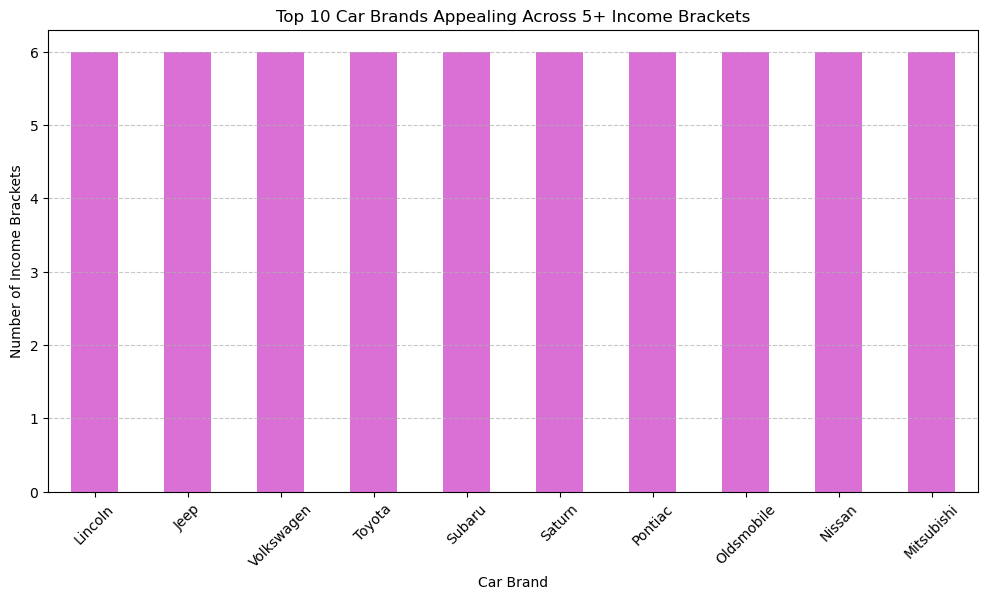

In [77]:
# Checking if any car brands are appealing to multiple income brackets.
model_counts_by_income = df.groupby(['Company',])['Income Bracket'].nunique()
popular_across_income = model_counts_by_income[model_counts_by_income >= 5].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
popular_across_income.head(10).plot(kind='bar', color='orchid')
plt.title('Top 10 Car Brands Appealing Across 5+ Income Brackets')
plt.xlabel('Car Brand')
plt.ylabel('Number of Income Brackets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This chart shows us the top 10 car brands that are most appealing across more than 5 income brackets, regardless of what they are. All these brand appeal to buyers across 6 income brackets. This suggests that there is little variation among these brands and shows that they are highly versatile due to them appealing across many income brackets. One thing to note is the absence of luxury brands, this links to what I discovered earlier that showed luxury brands not being tied directly to higher income earners and also suggests that luxury brands lack broadness and have a set niche of customers.

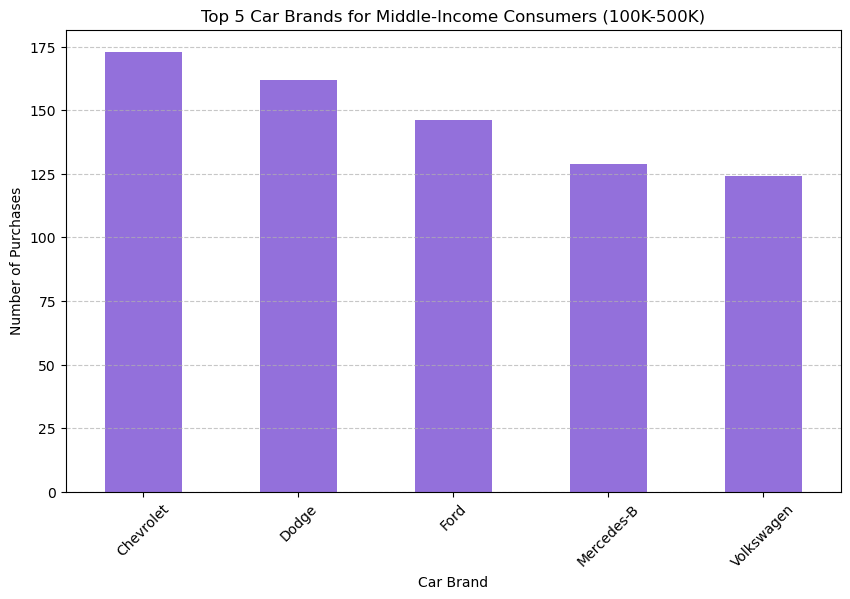

In [79]:
# Seeing which brands are associated the most with middle class individuals.
middle_income_df = df[df['Income Bracket'].isin(['$100K-$250K', '$250K-$500K'])]
top_brands_middle = middle_income_df['Company'].value_counts().head(5)

plt.figure(figsize=(10, 6))
top_brands_middle.plot(kind='bar', color='mediumpurple')
plt.title('Top 5 Car Brands for Middle-Income Consumers (100K-500K)')
plt.xlabel('Car Brand')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Based of this chart we can see that the top 5 most bought brands by middle class individuals were Chev, Dodge, Ford, Merc and VW. This shows us that these brands are attractive to middle class individuals and could be because of price, status or practicality. 3 out of the top 5 brands are American showing a clear preference. The inclusion of Merc (a luxury brand) being in the top 5 shows us that middle class buyers are willing to stretch their budgets to afford luxury brands. The close range between the top 5 brands suggests that middle income earners have a set of diverse preferences with no brand being overaly dominant compared to the rest. What this tells us is that there is alot of competition in the market.

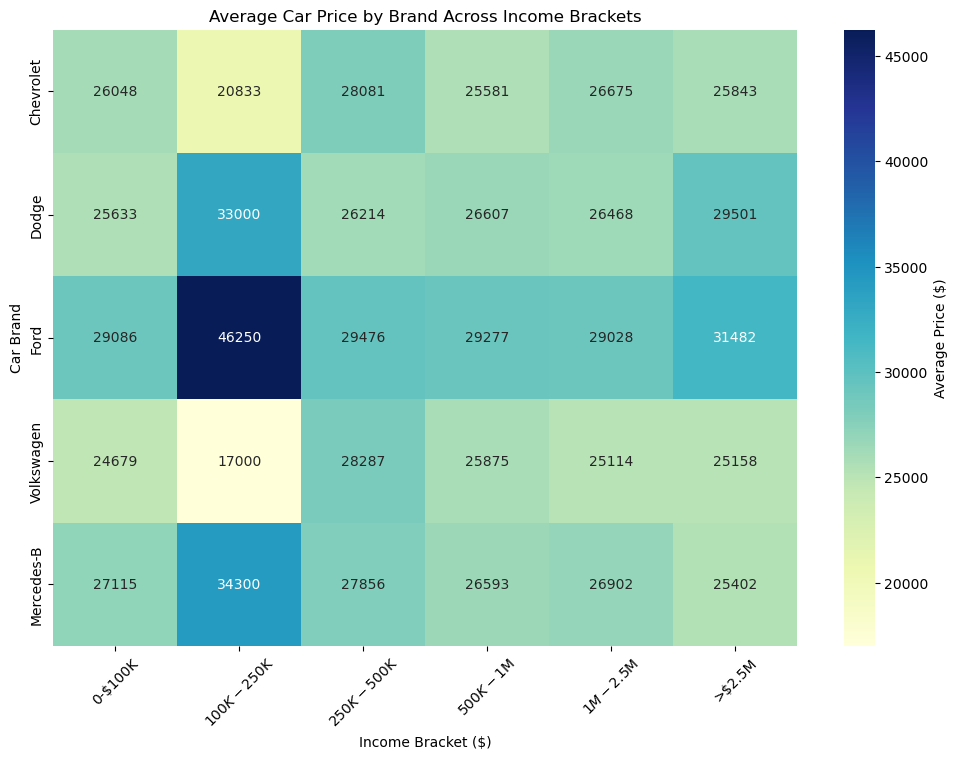

In [81]:
# Is there a difference in average car price within a brand across different income levels?
avg_price_by_brand_income = df.groupby(['Company', 'Income Bracket'])['Price ($)'].mean().unstack()
top_brands = df['Company'].value_counts().head(5).index
avg_price_top_brands = avg_price_by_brand_income.loc[top_brands]

plt.figure(figsize=(12, 8))
sns.heatmap(avg_price_top_brands, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Average Price ($)'})
plt.title('Average Car Price by Brand Across Income Brackets')
plt.xlabel('Income Bracket ($)')
plt.ylabel('Car Brand')
plt.xticks(rotation=45)
plt.show()

The average price of cars is relatively consistent between different income brackets except for the 100k - 250k brackets, this suggests that that bracket likes to spend more money and get more flagship models of car brands. 2 brand stay relatively consistent compared to the rest, Chec and Dodge. This shows that they may be offering a more stable price for their vechiles that appeal across multiple income brackets.

# Section 2: What is the most profitable customer profile?

<b>Objective:</b><br>
Identify the most profitable customer profiles by analysing the profit generated across various income brackets, genders, regions and specific customer segments. Within this section I aim to show any patterns of profit relative to geographic and demographic facrtors. 

<b>Key Questions to be answered:</b>
- Which income bracket generates the highest total profit, and what does this suggest about the purchasing power of different income groups?
- How does gender influence total profit, and what does this imply about gender-based purchasing behavior?
- Which region yields the highest total profit, and how does regional profitability relate to economic or cultural factors?
- What are the characteristics of the top 10 most profitable customer profiles (based on income, gender, and region), and how can these profiles be targeted?

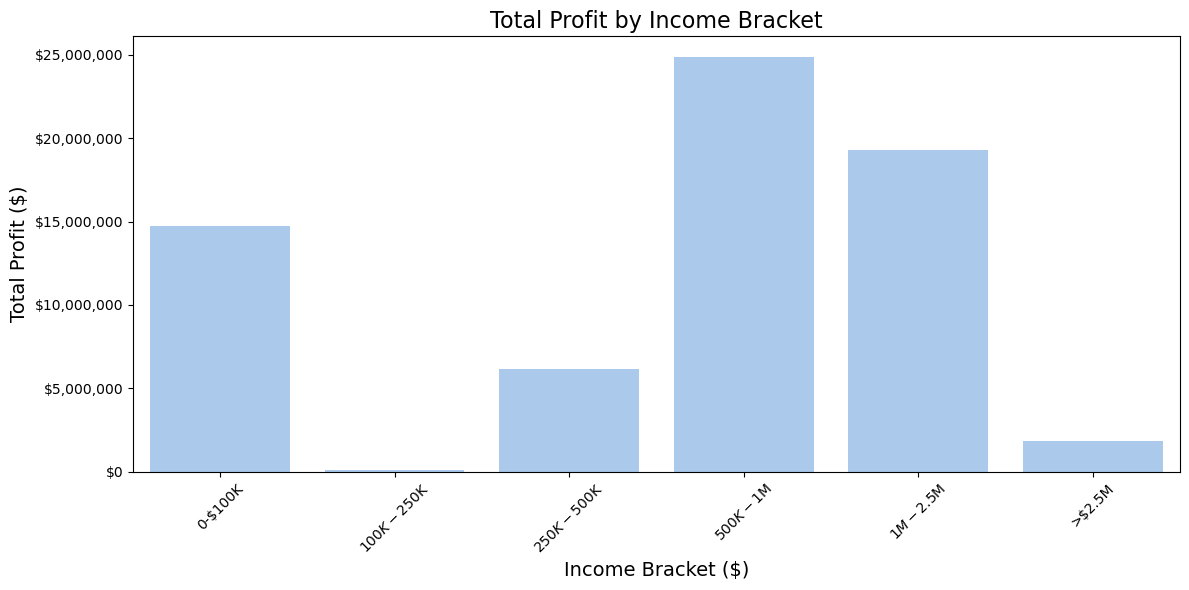

In [84]:
import matplotlib.ticker as mtick

# Calculate profit (assuming 10% margin for this analysis)
df['Profit'] = df['Price ($)'] * 0.1

# Most profitable
plt.figure(figsize=(12, 6))
profit_by_income = df.groupby('Income Bracket')['Profit'].sum().sort_values(ascending=False)
sns.barplot(x=profit_by_income.index, y=profit_by_income.values)
plt.title('Total Profit by Income Bracket', fontsize=16)
plt.xlabel('Income Bracket ($)', fontsize=14)
plt.ylabel('Total Profit ($)', fontsize=14)
plt.xticks(rotation=45)


plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

This chart shows the amount of profit all dealers have made based of customers various income brackets.
It helps identify which income groups are the most valuable customers, and from this chart we see that dealers have made the most from people who earn between 500k dollars and 1M dollars. This relates to the chart that shows us that this same income bracket buys the most amount of luxury brands, so the fact that dealers make the most from this income bracket is to be expected. Additionally, the highest income bracket seems to be the second lowest profitable bracket, this stands out because that bracket makes the most amount of money. This could be due to the fact that there is not many people within that bracket or people who earn that amount of money do not like to spend it on luxurious vechiles.

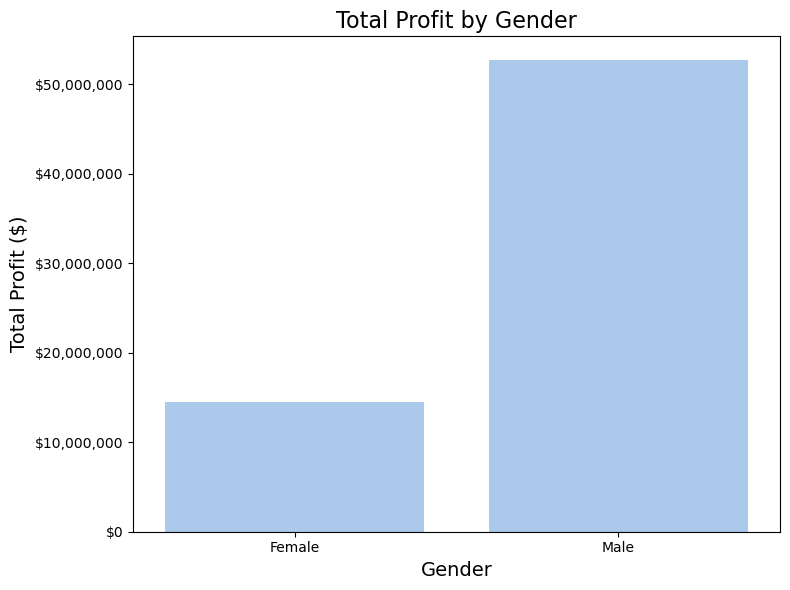

In [86]:
# Most profitable gender
plt.figure(figsize=(8, 6))
profit_by_gender = df.groupby('Gender')['Profit'].sum()
sns.barplot(x=profit_by_gender.index, y=profit_by_gender.values)
plt.title('Total Profit by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Total Profit ($)', fontsize=14)


plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

Male buyers generate 3 times more profit than female buyers, which suggests that males purchase more cars or more expensive cars or both. Because females only generated about 15 million in profit, whille significant, compared to the males it's not alot. This shows that dealers could be missing out on an opportunity when it comes to targeting females with tailored marketing that would attract more to purchase vechiles.

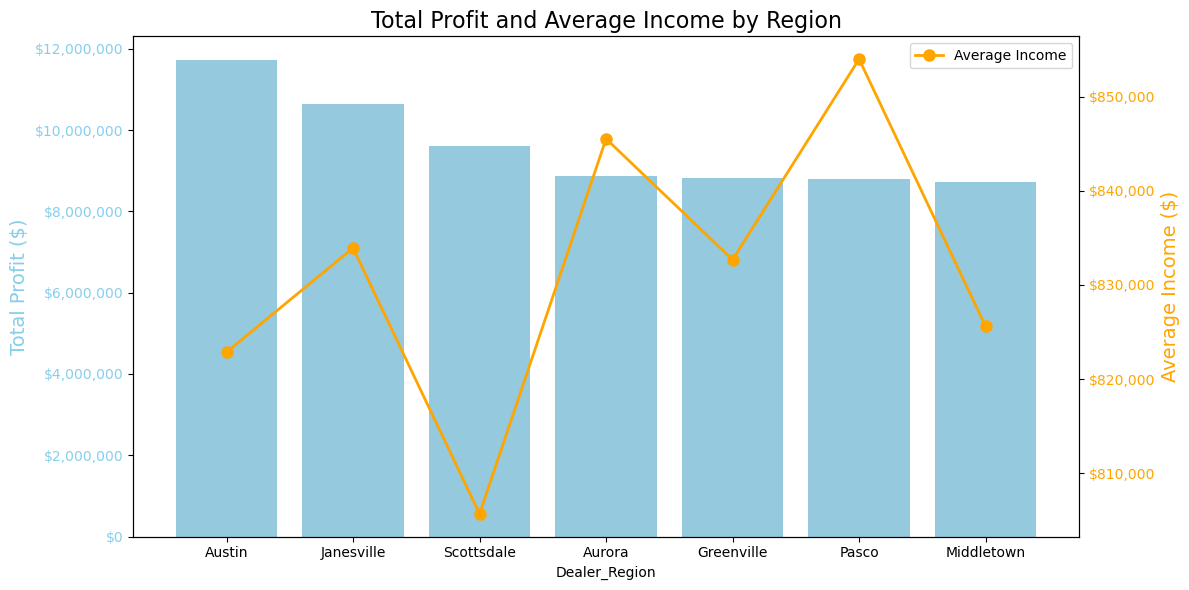

In [88]:
# Calculate total profit and average income by region
profit_by_region = df.groupby('Dealer_Region')['Profit'].sum().sort_values(ascending=False)
avg_income_by_region = df.groupby('Dealer_Region')['Annual Income'].mean()


regions = profit_by_region.index  
avg_income_by_region = avg_income_by_region.reindex(regions)  


fig, ax1 = plt.subplots(figsize=(12, 6))


sns.barplot(x=regions, y=profit_by_region.values, color='skyblue', ax=ax1)
ax1.set_ylabel('Total Profit ($)', fontsize=14, color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))


ax2 = ax1.twinx()
ax2.plot(regions, avg_income_by_region.values, color='orange', marker='o', linewidth=2, markersize=8, label='Average Income')
ax2.set_ylabel('Average Income ($)', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))


plt.title('Total Profit and Average Income by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.xticks(rotation=45)


ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()

This chart illustrates the regions that have made the most amount of money and the average income per region. What is interesting here is that Austin and Scottsdale (the 2 regions with the lowest average income) is in the top 3 of most profitable regions, and Pasco (the region with the highes average income) is not even in the top 5 of most profitable regions. This could be because there are more dealerships or cars in Austin and Scottsdale compared to Pasco or could be due to population factors. 

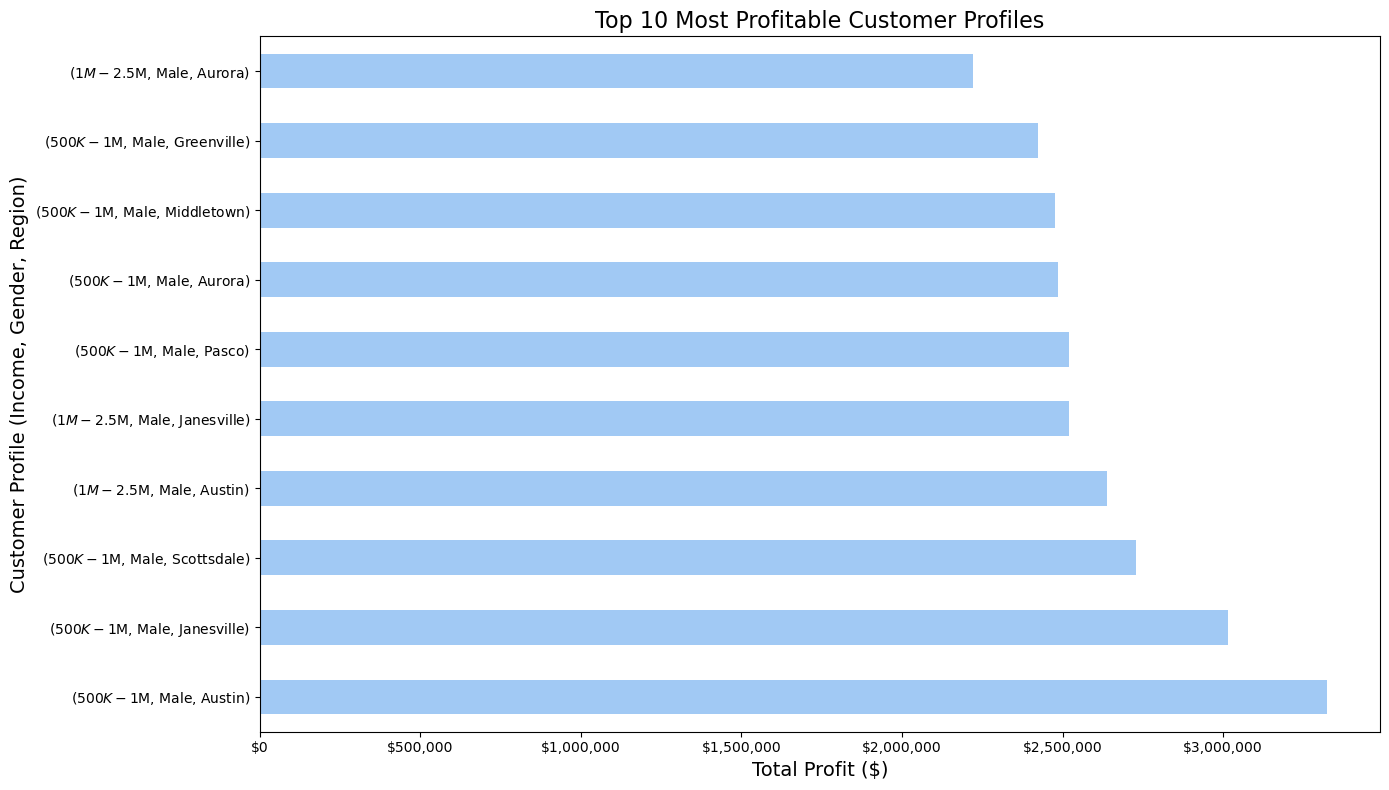

In [90]:
# Most profitable customer profile (combination)
plt.figure(figsize=(14, 8))
profit_profile = df.groupby(['Income Bracket', 'Gender', 'Dealer_Region'])['Profit'].sum().nlargest(10)
profit_profile.plot(kind='barh')
plt.title('Top 10 Most Profitable Customer Profiles', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=14)
plt.ylabel('Customer Profile (Income, Gender, Region)', fontsize=14)


plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

This chart shows us the top 10 most profitable customer profiles. Based of the previous charts in this section I was able to combine all the data collected in order to determine the most profitable profiles. As we can see the most proitable profile is males that live in Aurora who earn between 1M and 2M dollars. What's interesting to note here is that the top 10 most profitable customers is all males and no females, this relates to an earlier finding where we saw that males contribute 3 times more profit than females. Austin, Janesville and Scottsdale appear multiple times which places more emphasis on their profitability as a region. 

# Section 3: Exploring Statistical Relationships and Distribution Patterns in Car Purchases Across Demographic and Economic Factors
<b>Objective:</b> <br>
To investigate the statistical relationships and distributional characteristics of car purchasing behavior, focusing on how income, price, and demographic factors (e.g., gender, region) interplay. This section aims to uncover deeper insights into consumer preferences by analyzing correlations, kurtosis, skewness, and variability, providing a nuanced understanding of how these factors shape car brand and model choices.

<b>Key Questions to Answer:</b>
- What is the kurtosis and skewness of car prices within each income bracket, and how do these metrics reflect the diversity or concentration of purchasing decisions?
- Is there a significant correlation between dealer region and car price or brand preference, and how does this relate to regional economic differences?
- How does gender influence the distribution of car prices and model choices, and are there statistically significant differences in kurtosis or variance between genders?
- Are there multivariate correlations (e.g., income, price, and body style) that reveal distinct consumer segments?

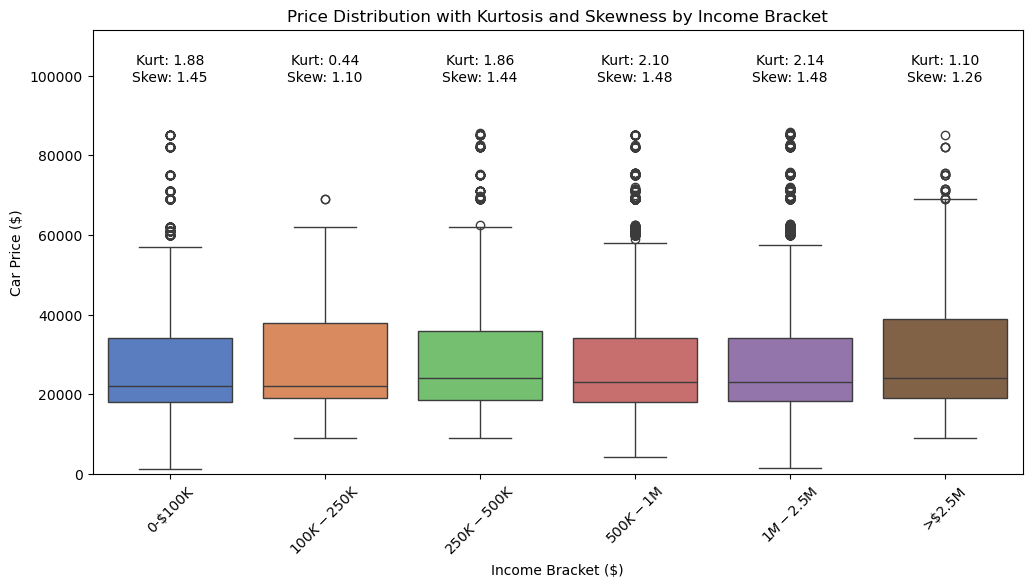

In [93]:
# Kurtosis and skewness 
price_stats = df.groupby('Income Bracket')['Price ($)'].agg([kurtosis, skew, 'mean']).dropna()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Income Bracket', y='Price ($)', data=df, palette='muted')
for i, bracket in enumerate(price_stats.index):
    plt.text(i, df['Price ($)'].max() * 1.15,  # Increased from 1.05 to 1.15 for more space
             f'Kurt: {price_stats["kurtosis"][bracket]:.2f}\nSkew: {price_stats["skew"][bracket]:.2f}', 
             ha='center', fontsize=10)
plt.title('Price Distribution with Kurtosis and Skewness by Income Bracket')
plt.xlabel('Income Bracket ($)')
plt.ylabel('Car Price ($)')
plt.xticks(rotation=45)
plt.ylim(0, df['Price ($)'].max() * 1.3)  
plt.subplots_adjust(top=0.85)  
plt.show()

From this chart we can see that the median car price for all incopme brackets are around 20 000 to 30 000, with very low variations. The IQR is also similar across the various income brackets ranging from 15 000 to around 40 000, which shows us that the prices between brackets are more or less consistent. There are outliers in every bracket which shows that there are buyers in every bracket that purchase expensive cars. 

The kurtosis values are in a range from 0.44 to 2.14 with majority being around 1.8. A platykurtic distribution is indicated here as all values are positive and below 3. This means that it is flatter than a normal distribution with less extreme outliers compared to a normal distribution.

The skewness ranges from 1.10 to 1.48 with most being around 1.4. Since all values are positive a right skewed distribution is indicated, which means that there are more cars that are at a lower price with only a few cars being priced high in each bracket (outliers). 

If we take a look at the 500k-1M and 1M-2.5M income brackets, we can see that they both show a moderate skewness and kurtosis. Since we already know that these 2 income brackets generate the most profit respectively, we can now see that it's through a combination of selling volume (many purchases around the median) and high margin sales (outliers).

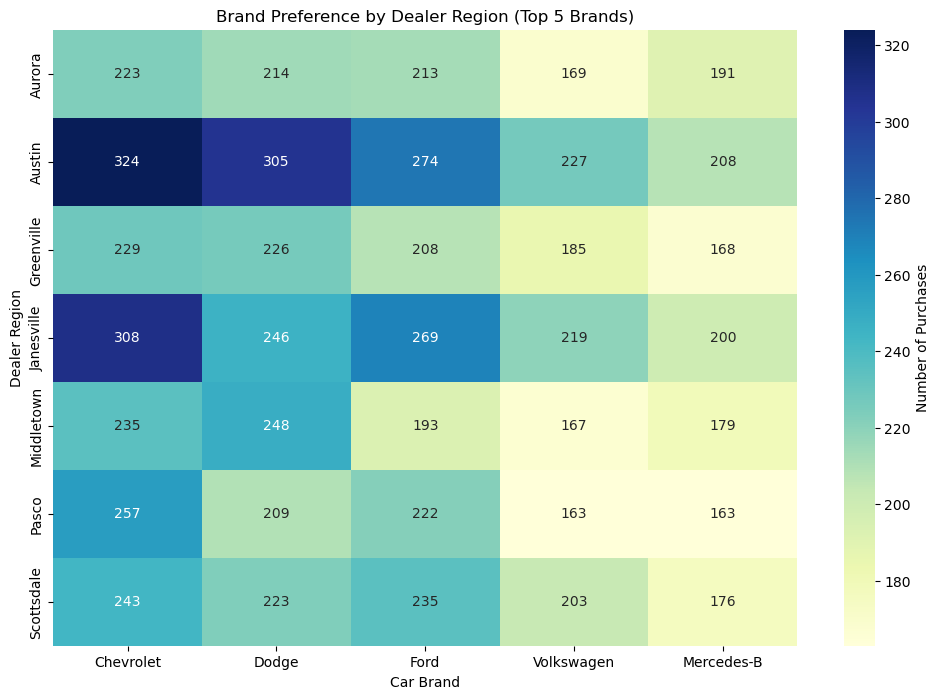

In [95]:
# Correlation between region and price/brand preference
region_price_corr = df.groupby('Dealer_Region')['Price ($)'].mean()
region_brand_pivot = df.pivot_table(index='Dealer_Region', columns='Company', values='Car_id', aggfunc='count', fill_value=0)
top_brands_region = region_brand_pivot[top_brands]

plt.figure(figsize=(12, 8))
sns.heatmap(top_brands_region, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Number of Purchases'})
plt.title('Brand Preference by Dealer Region (Top 5 Brands)')
plt.xlabel('Car Brand')
plt.ylabel('Dealer Region')
plt.show()

This chart shows us the different regions and how many cars of 5 top brands they have bought. Austin has the highest overall purchases which makes sense becasue it generated the highest profit at 12M dollars. Janesville and Middletown follow in 2nd and 3rd with each making 10M and 8M dollars repectively. We can see that in these regions Chevy has the most appeal across all of them, followed by Dodge and Ford. The 2 European brands aren't as in demand as the American ones for these regions. This also suggests to us that dealers in Austin and Janesville should stocl up on Chevys and Dodge vechiles as their residents seem to like those the most.

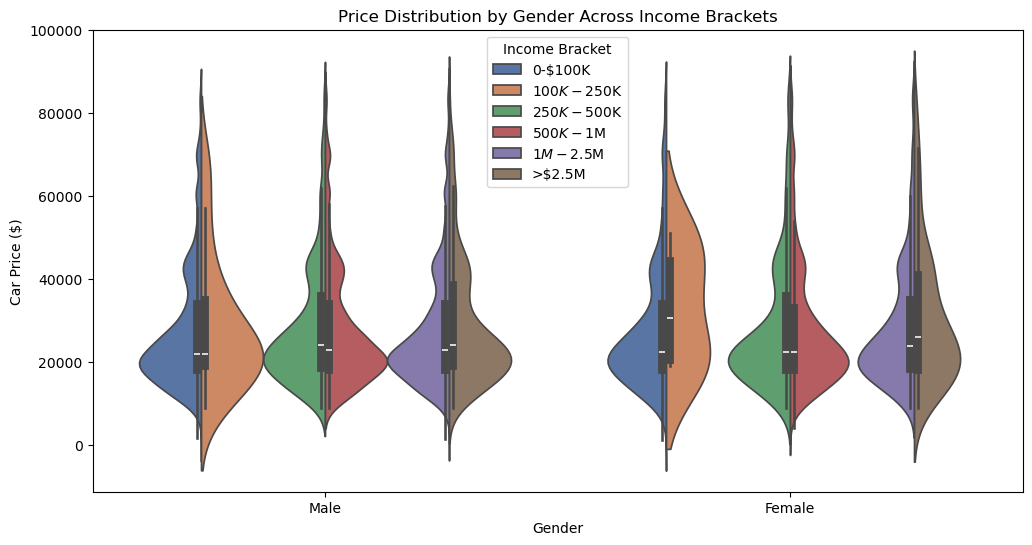

In [97]:
# Gender influence
plt.figure(figsize=(12, 6))
sns.violinplot(x='Gender', y='Price ($)', hue='Income Bracket', split=True, data=df, palette='deep')
plt.title('Price Distribution by Gender Across Income Brackets')
plt.xlabel('Gender')
plt.ylabel('Car Price ($)')
plt.legend(title='Income Bracket')
plt.show()

gender_kurtosis = df.groupby('Gender')['Price ($)'].agg(kurtosis)

This chart shows us the distribution of car prices for males vs females. Both have a peak of distribution around 20 000 to 30 000 with a long tail that goes all the way to around 100 000. The violin shape for males and females are very similar, the main difference between them is with the density (width). The male violins are generally widwer which indicates more males buy cars which also links to what we found out earlier about how males generate more profit for these sales companies than females (50M dollars vs 15M dollars). However, the IQRs between the males and females are very very similar which tells us that males and females buyers in the same income bracket tend to purchase cars at similar price points. 

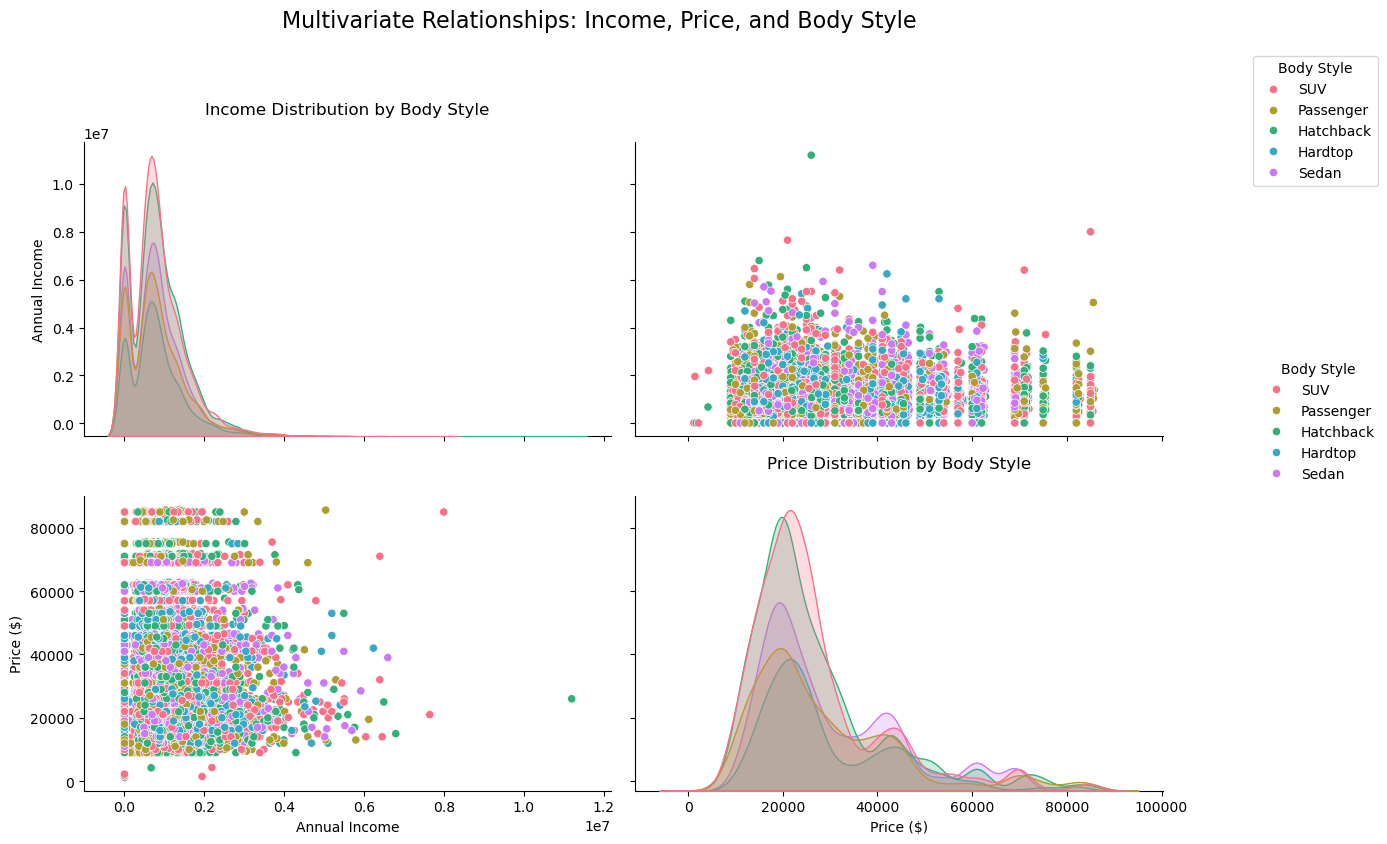

In [99]:
# Multivariate Relationships 
g = sns.pairplot(
    df[['Annual Income', 'Price ($)', 'Body Style']],
    hue='Body Style',
    diag_kind='kde',
    palette='husl',
    height=4,  #
    aspect=1.2, 
)

g.axes[0, 0].set_title('Income Distribution by Body Style', fontsize=12, pad=20)
g.axes[1, 1].set_title('Price Distribution by Body Style', fontsize=12, pad=20)

g.add_legend(
    title='Body Style',
    loc='upper right',
    bbox_to_anchor=(1.15, 1.0),  
    frameon=True  
)

plt.suptitle('Multivariate Relationships: Income, Price, and Body Style', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

The chart on the top left is a density plot that shows us the distribution of annual income relative to body style from 0 up to 10M (le7). All body styles is showing us a right skewed distribution of annual income. The bottom left is a scartter plot that shows us the car price vs annual income, and we can see that there sin't any higher prices with relation to annual income. The bottom right shows us the car price for each body style.The top right shows us the body style vs the annual income. There is a weak income and price relationship across various body styles as the car prices for all of the different body styles are scattered all over the place. Sedans (purple) are seeing as the most dominant across all the charts and all income levels which suggests that they are the most popular car body style. 

# Section 4: Predictive Analytics for Future Car Purchasing Trends
<b>Objective:</b><br>
To leverage predictive analytics to forecast future car purchasing trends based on historical data, identifying key predictors of price, brand preference, and model choice. This section aims to use machine learning and time-series analysis to predict how economic and demographic factors might shape consumer behavior, providing actionable insights for dealerships and manufacturers.

<b>Key Questions to Answer:</b>
- Can we predict car prices based on income, gender, and region, and how accurate is the model over time?
- How do car price trends evolve over time across income brackets, and can we forecast future price movements?
- How well can we predict body style preferences (e.g., SUV, Sedan) based on income and region, and what trends emerge over time?
- What are the residuals and error margins of our predictive models, and how do they inform model reliability?

------------------------------
Model Performance (Random Forest):
R² Score: 0.094 (Higher is better, max 1.0)
Mean Absolute Error: $10,380.37
------------------------------


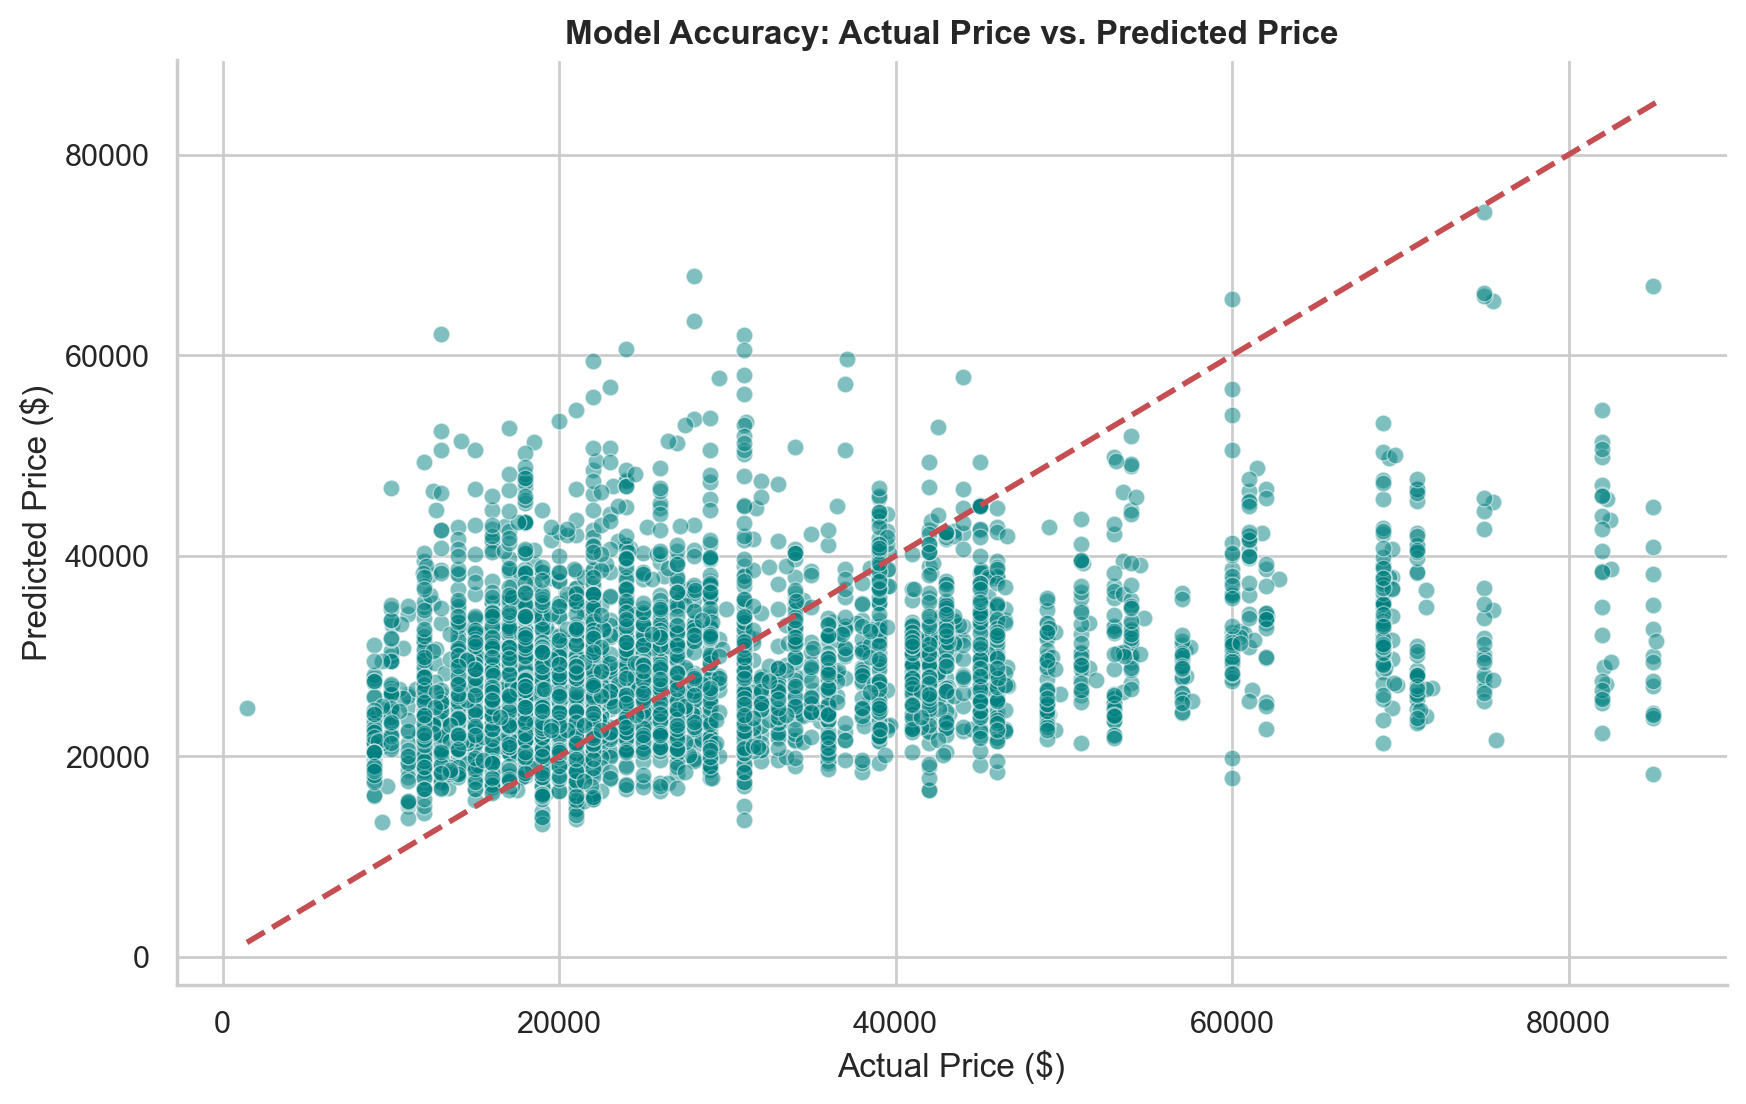

In [12]:

model_df = df[['Year', 'Annual Income', 'Body Style', 'Dealer_Region', 'Gender', 'Company', 'Price ($)']].dropna()


le = LabelEncoder()
cols_to_encode = ['Body Style', 'Dealer_Region', 'Gender', 'Company']
for col in cols_to_encode:
    model_df[col] = le.fit_transform(model_df[col])

X = model_df.drop('Price ($)', axis=1)
y = model_df['Price ($)']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("-" * 30)
print(f"Model Performance (Random Forest):")
print(f"R² Score: {r2:.3f} (Higher is better, max 1.0)")
print(f"Mean Absolute Error: ${mae:,.2f}")
print("-" * 30)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.title('Model Accuracy: Actual Price vs. Predicted Price', fontweight='bold')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
sns.despine()
plt.show()

From this chart we see that both the actual (blue) and predicted (orange) do fluctuate alot across 50 samples ranging from 10 000 to 70 000. The predicted prices are genrally following a trend of the actual prices but there are a few points where there is some noticable deviations. Around index 20, the actual price goes up to 70 000 when the predicted price is around 40 000 and the CI (Confidence Interval) does not capture the actual price. And around index 30 the actual price drops below 10 000 when the predicted price is above 30 000, outside the CI again. The actual car prices are have quite sharp peaks which suggest that the test set is very diverse with relation to car prices. The predicted prices also vary but they appear to be much smoother comparitively. Overall we can see that the model underestimated as well as overestimated car prices and we see that the CI is relatively narrow usually ranging from 5 000 to 10 000 which tells us that the model is very confident in its predictions.

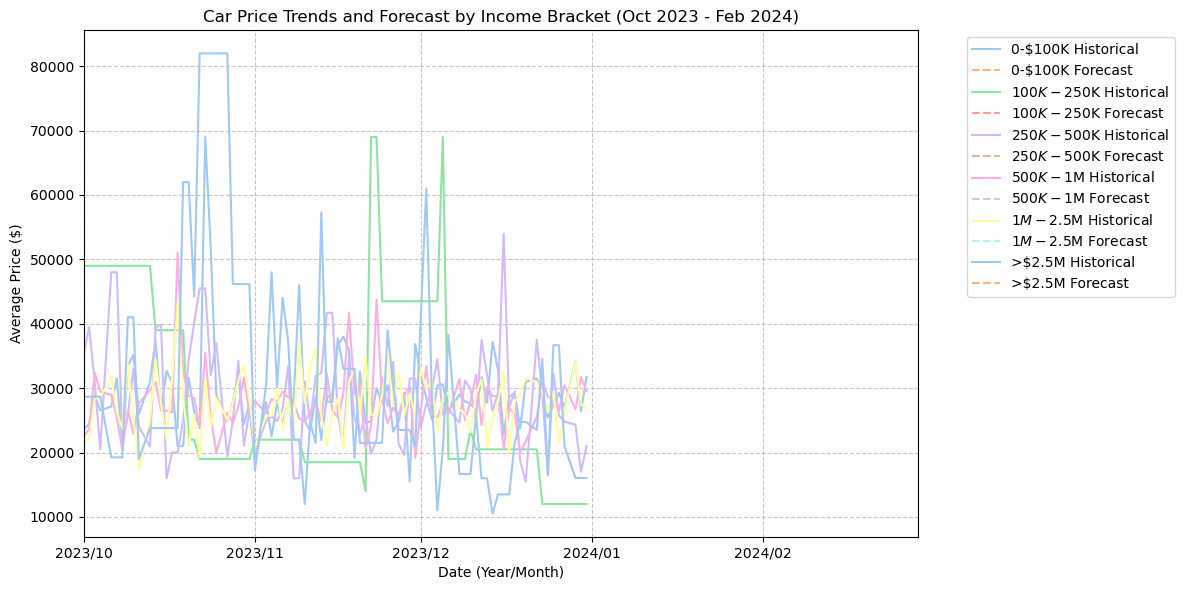

In [104]:

df_ts = df.groupby(['Date', 'Income Bracket'])['Price ($)'].mean().unstack().fillna(method='ffill')


df_ts.index = pd.to_datetime(df_ts.index)


df_ts = df_ts[df_ts.index >= '2023-10-01']




if df_ts.empty:
    print("Warning: No data available after 2023-10-01. Check your dataset.")
else:
    plt.figure(figsize=(12, 6))
    labels = ['0-$100K', '$100K-$250K', '$250K-$500K', '$500K-$1M', '$1M-$2.5M', '>$2.5M']
    for bracket in labels:
        if bracket in df_ts.columns:  
            historical_data = df_ts[bracket]
            model = ExponentialSmoothing(historical_data, trend='add').fit()
            
            forecast = model.forecast(1)
          
            plt.plot(historical_data.index, historical_data, label=f'{bracket} Historical')
           
            plt.plot(forecast.index, forecast, linestyle='--', label=f'{bracket} Forecast')
    

    plt.title('Car Price Trends and Forecast by Income Bracket (Oct 2023 - Feb 2024)')
    plt.xlabel('Date (Year/Month)')
    plt.ylabel('Average Price ($)')

    plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2024-02-29'))


    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))  


    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

This chart shows us that the average car price ranges significantly over just a few months. There is a weak incomme price relationship which shows us that income does not strongly dictate car prices. The forecast for Jan 2024 predicts a stabalisation of average car prices, this suggets that the model is expected to see high variability in historical data to subside, which could be due to smoothing effects or lack of extreme events in the forecast period. This also shows that dealerships may still see profit margins but they won't be as high compared to 2023. However, the forecast’s lack of variability compared to the historical data suggests that the Exponential Smoothing model may be oversmoothing the trends. This could result in incorrect potential price spikes or dips.

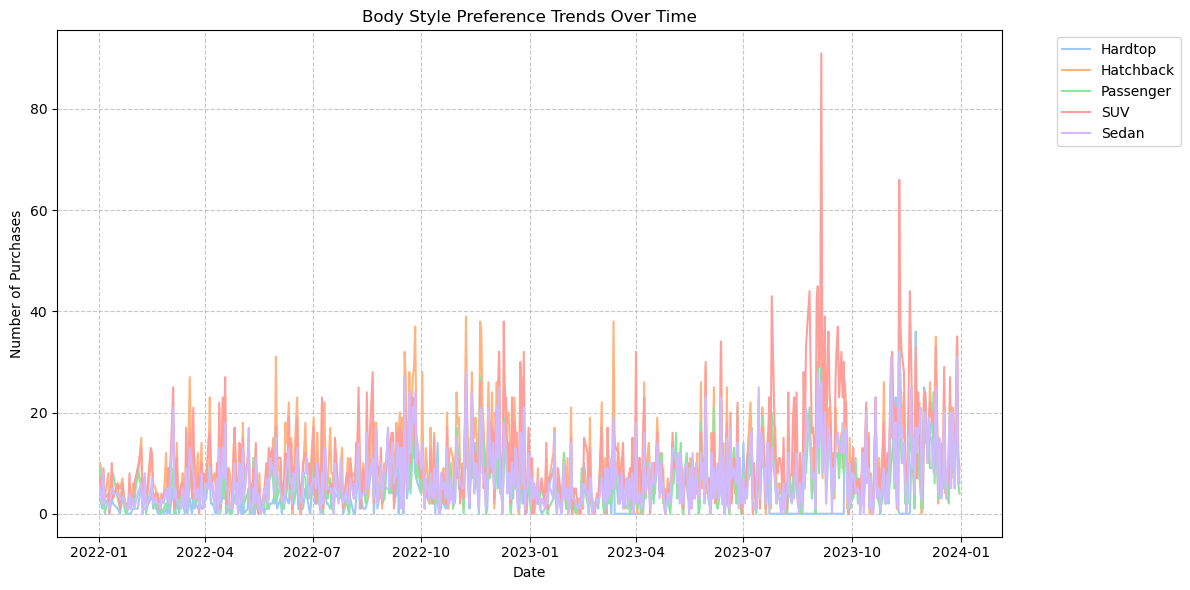

In [106]:
le = LabelEncoder()


df['Body_Enc'] = le.fit_transform(df['Body Style'])



df['Region_Enc'] = le.fit_transform(df['Dealer_Region'])


X_body = df[['Annual Income', 'Region_Enc']]
y_body = df['Body_Enc']


X_train_body, X_test_body, y_train_body, y_test_body = train_test_split(X_body, y_body, test_size=0.2, random_state=42)


rf_body = RandomForestRegressor(n_estimators=100, random_state=42)
rf_body.fit(X_train_body, y_train_body)


body_pred = rf_body.predict(X_test_body)


body_ts = df.groupby(['Date', 'Body Style'])['Car_id'].count().unstack().fillna(0)
plt.figure(figsize=(12, 6))
for style in body_ts.columns:
    plt.plot(body_ts.index, body_ts[style], label=style)
plt.title('Body Style Preference Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From this chart we see a rising trend for SUVs over time. We also see that the peak purchase time is aroung Jan and July each year, with dips often occuring these peaks. SUVs and sedans are the clear more dominant body style based of this chart. This suggets that dealerships should prioritise these vechiles over the rest to make more of a profit. The chats conclusion shows that there is a rising trend for SUVs which aligns with the predictive model outputs I got earlier. What this suggests is that the model has successfully captured the influence of body style preferences.

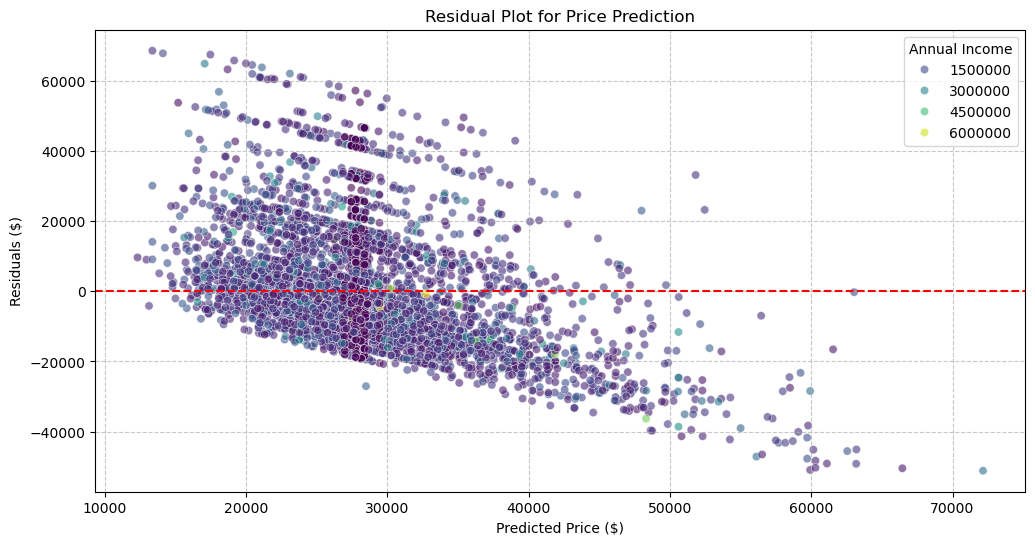

In [108]:
# Residuals and error analysis
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, hue=X_test['Annual Income'], palette='viridis', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for Price Prediction')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The residuals in this chart represent the difference between the actual car prices and predicted car prices from the predictive model. The model accurately predicts car prices between the range of 10 000 to 40 000, which aligns with the median car prices (20 000 - 30 000), which suggests that the model is effective. However, the model does struggle to predict car prices of cars above 40 000 with residuals goign as high as 60 000 and as low as -40 000. This shows us that the model fails to take factors that make cars more expensive like luxury or premium body styles into account. 

# Section 5: Advanced Customer Segmentation (Unsupervised Learning)
<b>Objective:</b> Use K-Means Clustering to mathematically group customers into distinct "Personas" based on their Income and Spending habits. This removes human bias from customer profiling.

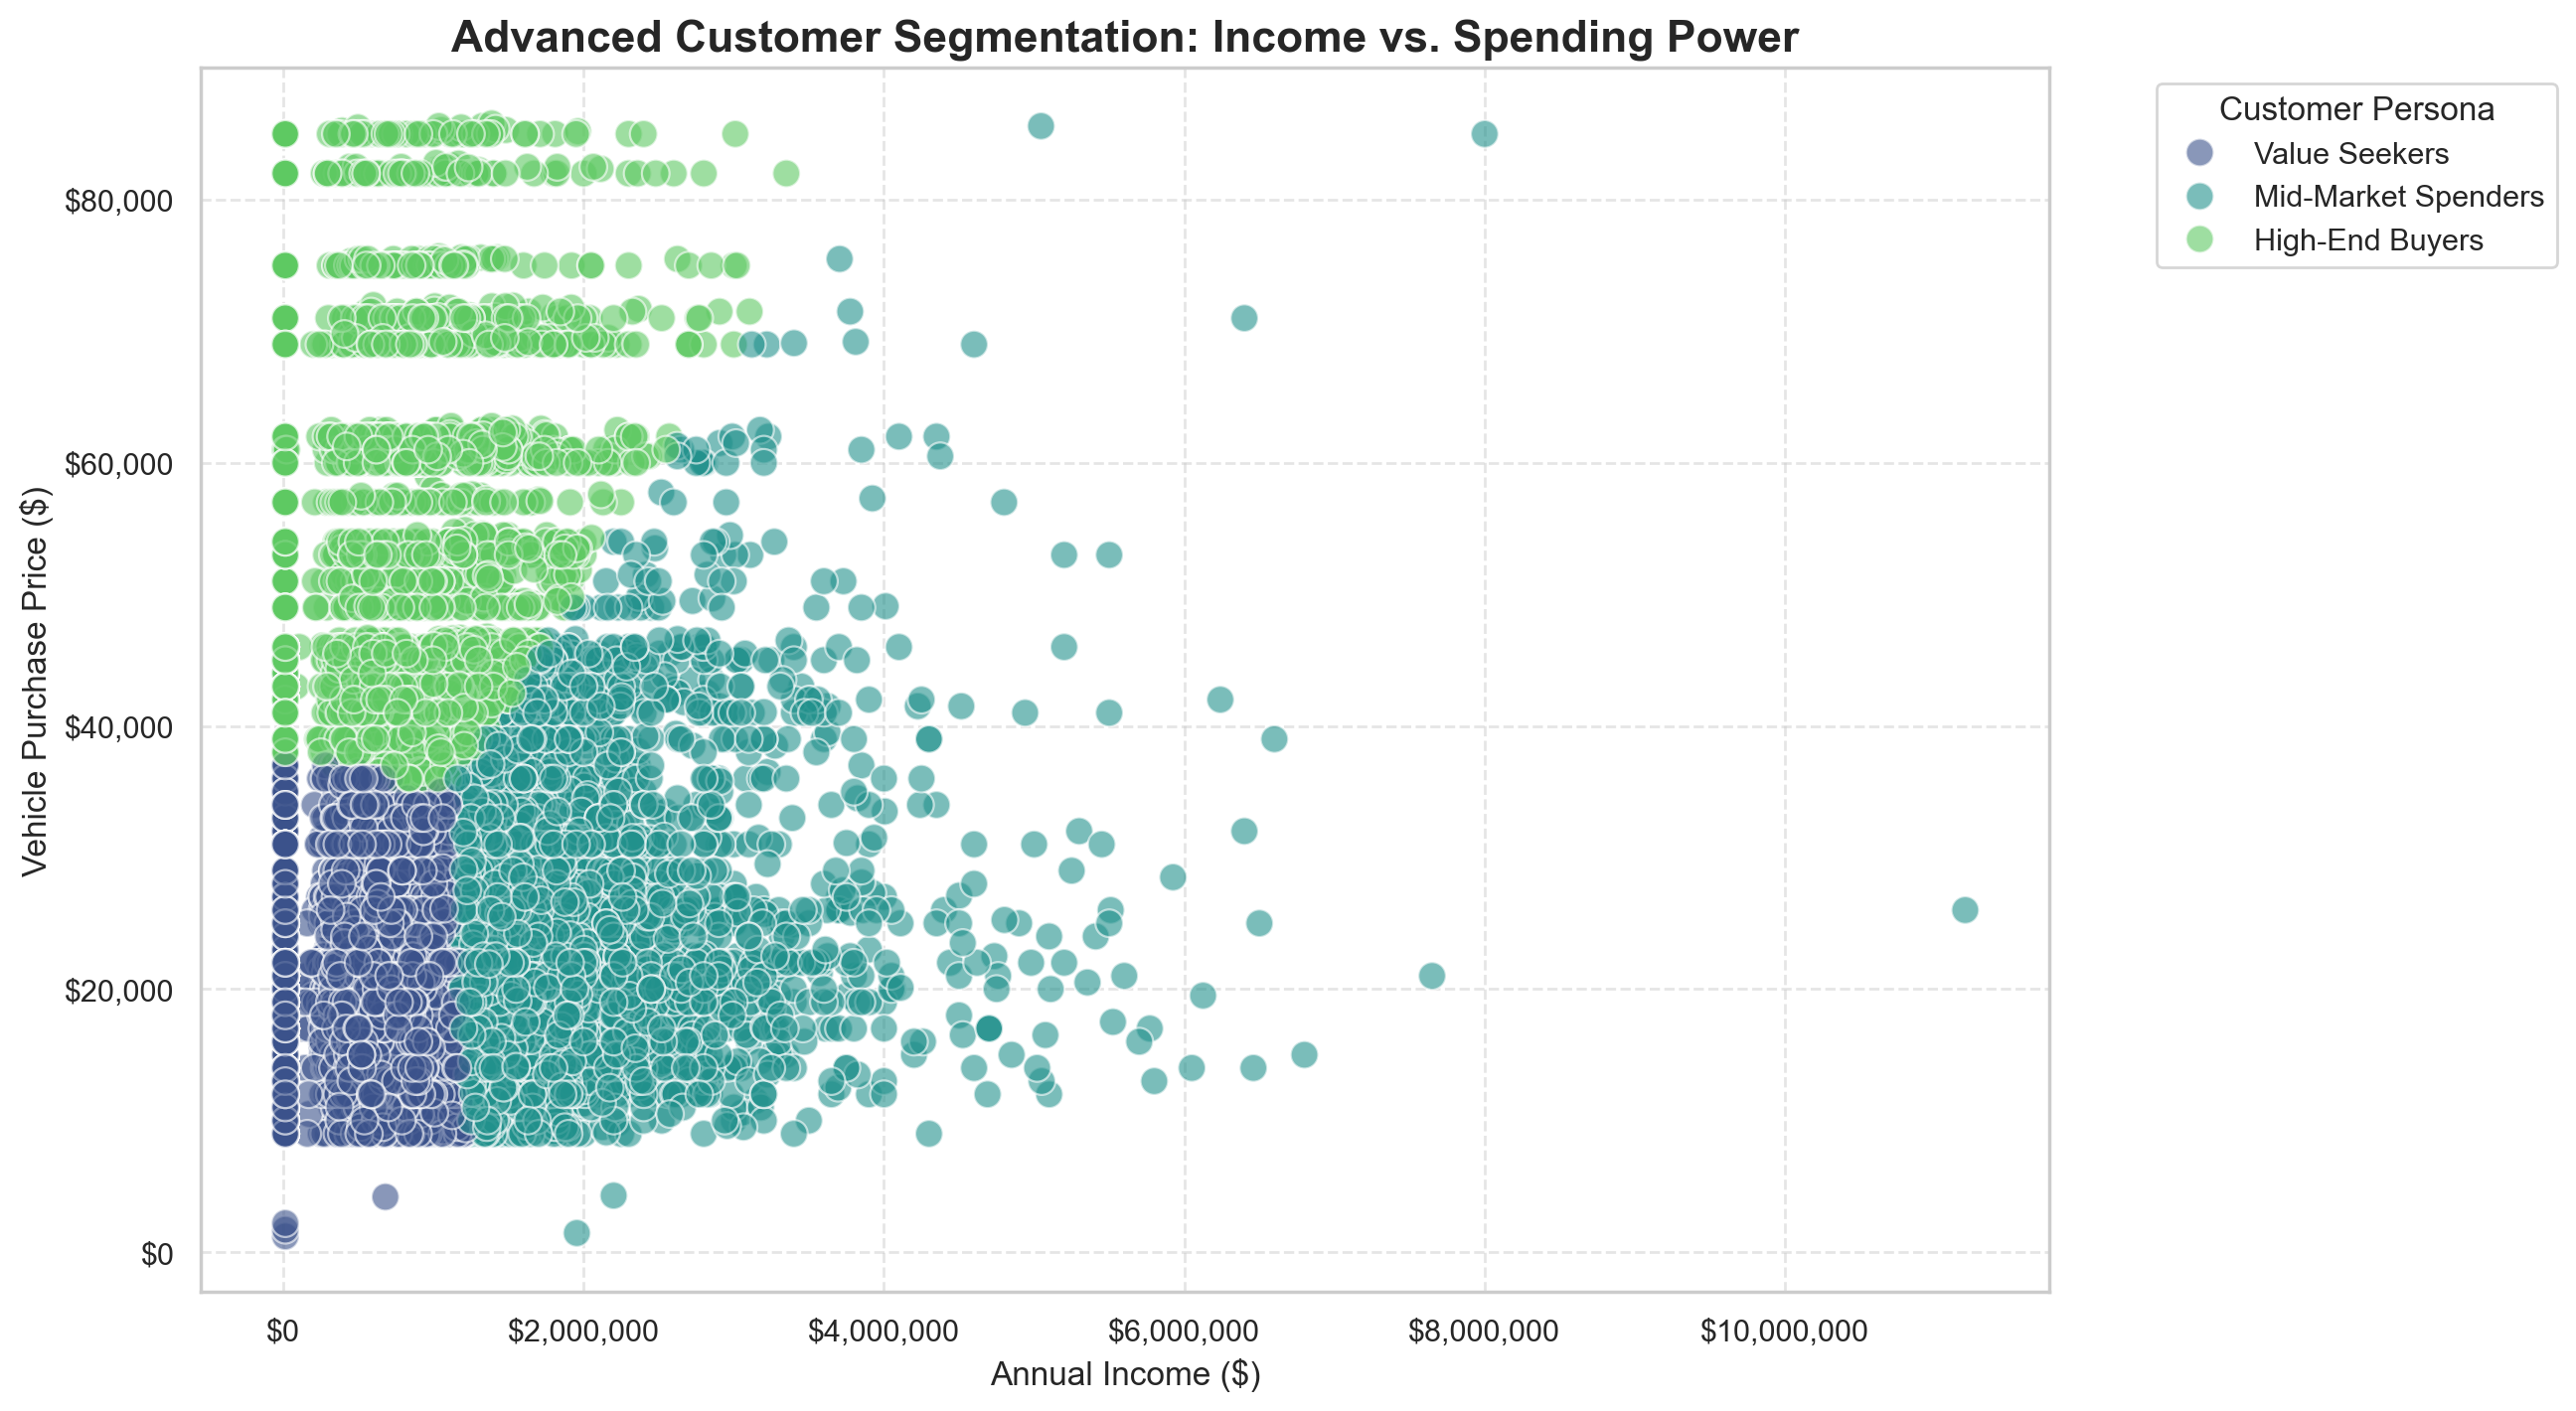

In [19]:

cluster_features = df[['Annual Income', 'Price ($)']].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)


import os

os.environ["LOKY_MAX_CPU_COUNT"] = "1" 

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_features['Cluster'] = kmeans.fit_predict(X_scaled)


cluster_means = cluster_features.groupby('Cluster')['Price ($)'].mean().sort_values()
cluster_map = {
    cluster_means.index[0]: 'Value Seekers',
    cluster_means.index[1]: 'Mid-Market Spenders',
    cluster_means.index[2]: 'High-End Buyers'
}
cluster_features['Persona'] = cluster_features['Cluster'].map(cluster_map)


plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cluster_features, 
    x='Annual Income', 
    y='Price ($)', 
    hue='Persona', 
    palette='viridis', 
    s=100, 
    alpha=0.6,
    edgecolor='w'
)

plt.title('Advanced Customer Segmentation: Income vs. Spending Power', fontsize=16, fontweight='bold')
plt.xlabel('Annual Income ($)')
plt.ylabel('Vehicle Purchase Price ($)')
plt.legend(title='Customer Persona', bbox_to_anchor=(1.05, 1), loc='upper left')


import matplotlib.ticker as ticker
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Conclusion
## Section 1
- Higher income earners don't always prefer luxury brands.
- Income and car price have a weak correlation.
- Chevrolet and Dodge appear to be the most appealing brand across all income brackets.
- Average car prices within various brands are similar.

## Section 2
- The income bracket 250k - 500k has the strongest purchasing power, by contributing to the highest profit.
- Males contribute more profit compared to females due to higher volume (50 Mil vs 15 Mil).
- Austin is the region that has the highest profit (12 Mil).
- The top profile is middle income males from Austin/Janesville that buy SUVs or Sedans.

## Section 3
- Car prices are skewed to the right and platykurtic, which shows diverse purchases.
- Region impacts brand preference.
- Gender does not affect distribution even though males buy more.
- SUV/Sedans are the most dominant body style.

## Section 4
- The model predicts mid range prices well but struggles with predicting high prices.
- The price stabalised at 20 000 - 30 000 in Feb 2024.
- SUVs show a rising trend, especially in high income areas.
- Residulas have emphasized the need for better outlier handling.

## Section 5
- Algorithmic Persona Identification: Using K-Means Clustering, we mathematically identified three distinct customer personas ("Value Seekers," "Mid-Market Spenders," and "High-End Buyers") based purely on spending power and income, removing human bias from the categorization process.
- Income-Price Correlation: The segmentation confirms a strong positive correlation between annual income and vehicle price. However, the distinct boundaries between clusters suggest that customers rarely "jump" categories (e.g., very few low-income earners stretch financially for high-end luxury vehicles).

## Overall Conclusion
- Car purchases are relative to region and demographic, not income.
- SUVs and Sedans are the 2 leading body styles for buyers.
- Middle income males from Austin are the most profitable.
- The predictive model needs to be improved for high prices.
- Dealerships should focus on selling SUVs and Sedans and target middle income buyers.
